## Introduction and Objective

The National Basketball Association (NBA) Rookie of the Year Award is granted to the best first-year player each year following the conclusion of the regular season. Winners are awarded the Wilt Chamberlain Trophy, named after the former Rookie of the Year and four-time Most Valuable Player award winner. A coalition of American and Canadian sports journalists votes for the Rookie of the Year. They may cast a first-place vote worth 5 points, a second-place vote worth 3 points, and a third-place vote worth 1 point. The player who accumulates the most points is declared Rookie of the Year. <br>
*Source*: "Sportskeeda. (2023). *List of NBA Rookie of the Year Award Winners*. https://www.sportskeeda.com/basketball/list-of-nba-rookie-of-the-year-award-winners 

In this notebook, I will implement two weighted logistic regression models to predict the winner of the NBA Rookie of the Year Award based on rookie players' pre-All-Star Break performance. I will scrape data from the official NBA website, limiting my sample to 1st-round draft picks from the last 20 seasons (i.e., from the 2002-03 season to the 2022-23 season). My rationale for only including 1st-round draft picks is all Rookie of the Year Award winners from the last 20 seasons were drafted in the 1st-round. I also chose to only include statistics up to the All-Star break (which is about 70% way through the regular season) to maximize the predictive capabilities of my model. I will clean and then analyze the data with tables and boxplots to determine the most important statistics for predicting Rookie of the Year winners. I will then preprocess the data to train my models, evaluate their initial performance with a confusion matrix, and tune them by adjusting hyperparameters. Afterward, I will divide up the players in the testing set by season, use the model to predict their respective probabilities of winning the Rookie of the Year Award, and declare players with the highest probability in each season as predicted winners. I will evaluate and visualize the accuracy of these predictions using a confusion matrix. 

## Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## Scrape Data from *nba.com*

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

season = "2002-03"
dfs_list = []

while season != "2023-24":
    # Start a new instance of Firefox web browser
    driver = webdriver.Firefox()

    # Navigate to the URL
    url = ("https://www.nba.com/stats/players/traditional?PlayerExperience=Rookie&PerMode=Totals&SeasonSegment="
           + "Pre+All-Star&DraftPick=1st+Round&Season=" + season)
    driver.get(url)

    # Wait for the table to load
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, "Crom_table__p1iZz")))

    # Get the table content
    table = driver.find_element(By.CLASS_NAME, "Crom_table__p1iZz")
    table_html = table.get_attribute("outerHTML")

    # Read the table into a pandas DataFrame
    df = pd.read_html(table_html)[0]
    
    # Add rookie season column to dataframe
    df['Rookie Season'] = season
    
    # Append df to df_list
    dfs_list.append(df)
    
    # Update season
    year = int(season[:4]) # Set year to int represented by first 4 characters of season
    year += 1
    # Next season represented by 4 chars of following year, a hyphen, and last two chars of following year
    season = str(year) + '-' + str(year + 1)[2:]  
    
    # Close the browser
    driver.quit()
    
# Merge dataframes in df_lists into one dataframe
rookies_df = pd.concat(dfs_list)

In [ ]:
rookies_df.head()

In [ ]:
rookies_df.to_csv("rookies.csv", index = False)

In [3]:
rookies_df = pd.read_csv("rookies.csv") # Read in rookies_df from CSV so we don't have to webscrape again

## Data Cleaning

In [4]:
rookies_df.shape

(614, 57)

In [5]:
rookies_df.columns

Index(['Unnamed: 0', 'Player', 'Team', 'Age', 'GP', 'W', 'L', 'Min', 'PTS',
       'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3',
       '+/-', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS RANK',
       'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
       'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
       'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'PF RANK',
       'FP RANK', 'DD2 RANK', 'TD3 RANK', '+/- RANK', 'Rookie Season'],
      dtype='object')

First, delete columns containing only NaN values. The  data pertaining to these columns (overall rankings) were unlikely to be relevant to selecting Rookie of the Year Award winners anyway since NBA players gain little experience during their rookie seasons. 

In [6]:
rookies_df = rookies_df.dropna(axis = 1, how = 'all')

In [7]:
rookies_df.head()

,Unnamed: 0,Player,Team,Age,GP,W,L,Min,PTS,FGM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie Season
0,1,Caron Butler,MIA,23,49,17,32,1804.5,681,241,...,130,107,86,17,140,1396,3,0,-128,2002-03
1,2,Amar'e Stoudemire,PHX,20,50,29,21,1562.1,640,220,...,42,110,38,45,166,1389,18,0,-27,2002-03
2,3,Yao Ming,HOU,22,48,26,22,1330.1,622,227,...,76,94,15,95,136,1439,16,0,18,2002-03
3,4,Drew Gooden,ORL,21,47,13,34,1258.6,586,244,...,63,100,37,21,114,1092,5,0,-153,2002-03
4,5,Dajuan Wagner,CLE,20,35,7,28,1081.1,507,182,...,99,63,34,5,83,777,1,0,-162,2002-03


Next, delete the column 'Unnamed: 0'. This column was merely used to rank players from each season by points scored, which is redundant since points scored is already included in the dataset.  

In [8]:
rookies_df = rookies_df.drop(columns = ['Unnamed: 0'])

In [9]:
rookies_df.head()

,Player,Team,Age,GP,W,L,Min,PTS,FGM,FGA,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie Season
0,Caron Butler,MIA,23,49,17,32,1804.5,681,241,608,...,130,107,86,17,140,1396,3,0,-128,2002-03
1,Amar'e Stoudemire,PHX,20,50,29,21,1562.1,640,220,489,...,42,110,38,45,166,1389,18,0,-27,2002-03
2,Yao Ming,HOU,22,48,26,22,1330.1,622,227,429,...,76,94,15,95,136,1439,16,0,18,2002-03
3,Drew Gooden,ORL,21,47,13,34,1258.6,586,244,547,...,63,100,37,21,114,1092,5,0,-153,2002-03
4,Dajuan Wagner,CLE,20,35,7,28,1081.1,507,182,489,...,99,63,34,5,83,777,1,0,-162,2002-03


Check for more missing values:

In [10]:
rookies_df.isnull().sum()

Player           0
Team             0
Age              0
GP               0
W                0
L                0
Min              0
PTS              0
FGM              0
FGA              0
FG%              0
3PM              0
3PA              0
3P%              0
FTM              0
FTA              0
FT%              0
OREB             0
DREB             0
REB              0
AST              0
TOV              0
STL              0
BLK              0
PF               0
FP               0
DD2              0
TD3              0
+/-              0
Rookie Season    0
dtype: int64

Check for duplicate rows: 

In [11]:
rookies_df.duplicated().sum()

0

Each column contains a complete set of data and no rows are duplicated. So, we can now break down the columns explicity related to the player's athletic performance during their rookie season.  

- GP: Games Played<br><br>  
- W: Wins <br><br>  
- L: Losses <br><br>  
- Min: Minutes Played <br><br>  
- PTS: Total points scored over the season <br><br>
- FGM: Field Goals Made <br><br>  
- FGA: Field Goals Attempted <br><br> 
- FG%: Field Goal Percentage  <br><br> 
- 3PM: Three-Point Field Goals Made <br><br> 
- 3PA: Three-Point Field Goals Attempted <br><br> 
- 3P%: Three-Point Field Goal Percentage <br><br> 
- FTM: Free-Throws Made <br><br>
- FTA: Free-Throws Attempted <br><br>
- FT%: Free-Throw Percentage <br><br>
- OREB: Offensive Rebounds <br><br>
- DREB: Defensive Rebounds <br><br>
- REB: Total Rebounds <br><br>
- AST: Assists <br><br>
- TOV: Turnovers <br><br>
- STL: Steals <br><br>
- BLK: Blocks <br><br>
- PF: Personal Fouls <br><br>
- FP: Fantasy Points (Point system developed for a sports betting game in which players act as the manager of their own team and draft players. In the NBA, fantasy points are calculated as followed: <br><br>
    - Points: 1 point

    - Rebounds 1.2 points

    - Assists: 1.5 points

    - Steals/Blocks: 3 points

    - Turnovers: -1 point
  
   - *Source*: Barutha, A. (2023, August 17). *Advice for NBA fans new to Fantasy Basketball*. NBA Fantasy. https://www.nba.com/news/advice-for-nba-fans-new-to-fantasy-basketball  <br><br>
- DD2: Double-Doubles (Number of games where player accumulates double digits in two separate performance metrics. For example, 15 points and 10 rebounds is a double-double). <br><br>
- TD3: Triple-Doubles (Number of games where player accumulates double digits in three separate performance metrics). <br><br>
- +/-: Plus/Minus (Point differential while the player is on the court. Calculated by: points scored by player's team - points scored by opponent while the player is on the court) <br><br>

Next, add the target column: Rookie of the Year. A 1 will indicate that a player won the Rookie of the Year Award for that season, and a 0 otherwise. 

In [12]:
roty_winners = {
    "2022-23": "Paolo Banchero",
    "2021-22": "Scottie Barnes",
    "2020-21": "LaMelo Ball",
    "2019-20": "Ja Morant",
    "2018-19": "Luka Doncic",
    "2017-18": "Ben Simmons",
    "2016-17": "Malcolm Brogdon",
    "2015-16": "Karl-Anthony Towns",
    "2014-15": "Andrew Wiggins",
    "2013-14": "Michael Carter-Williams",
    "2012-13": "Damian Lillard",
    "2011-12": "Kyrie Irving",
    "2010-11": "Blake Griffin",
    "2009-10": "Tyreke Evans",
    "2008-09": "Derrick Rose",
    "2007-08": "Kevin Durant",
    "2006-07": "Brandon Roy",
    "2005-06": "Chris Paul",
    "2004-05": "Emeka Okafor",
    "2003-04": "LeBron James",
    "2002-03": "Amar'e Stoudemire"
}

# Iterate over roty_winners dictionary 
for season, player in roty_winners.items():
    # Find the rows where the player won Rookie of the Year for a specific season
    mask = (rookies_df['Player'] == player) & (rookies_df['Rookie Season'] == season)
    
    # Update the 'Rookie of the Year' column for those rows by filling in 1s, indicating
    # the player won Rookie of the Year Award
    rookies_df.loc[mask, 'Rookie of the Year'] = True

# Fill remaining spaces with 0s to represent non-winners
rookies_df = rookies_df.fillna(False) 
rookies_df['Rookie of the Year'] = rookies_df['Rookie of the Year'].astype(int)

In [13]:
rookies_df.head()

,Player,Team,Age,GP,W,L,Min,PTS,FGM,FGA,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie Season,Rookie of the Year
0,Caron Butler,MIA,23,49,17,32,1804.5,681,241,608,...,107,86,17,140,1396,3,0,-128,2002-03,0
1,Amar'e Stoudemire,PHX,20,50,29,21,1562.1,640,220,489,...,110,38,45,166,1389,18,0,-27,2002-03,1
2,Yao Ming,HOU,22,48,26,22,1330.1,622,227,429,...,94,15,95,136,1439,16,0,18,2002-03,0
3,Drew Gooden,ORL,21,47,13,34,1258.6,586,244,547,...,100,37,21,114,1092,5,0,-153,2002-03,0
4,Dajuan Wagner,CLE,20,35,7,28,1081.1,507,182,489,...,63,34,5,83,777,1,0,-162,2002-03,0


We now have a complete and comprehensive data set containing the target column. We will now analyze this data more thoroughly and preprocess the data to train the model. ` 

## Data Visualization, Analysis, Preprocessing

We will start by comparing the summary statistics for Rookie of the Year Award winners and non-winners.

In [14]:
# Separate the data into players who won the Rookie of the Year Award and those who did not
winners = rookies_df[rookies_df['Rookie of the Year'] == 1]
non_winners = rookies_df[rookies_df['Rookie of the Year'] == 0]

### Rookie of the Year Winners Summary Statistics

In [15]:
winners.describe()

,Age,GP,W,L,Min,PTS,FGM,FGA,FG%,3PM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie of the Year
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.0
mean,20.450000,47.650000,19.750000,27.90000,1639.245000,837.900000,311.450000,688.400000,45.325000,39.100000,...,214.750000,128.850000,55.900000,30.450000,115.600000,1657.150000,11.850000,0.60000,-105.900000,1.0
std,1.050063,7.693299,6.381511,7.09262,332.236654,208.813163,79.846876,169.396887,4.110433,35.246351,...,113.056518,37.660918,22.142838,22.702828,31.714848,392.587808,11.694691,1.46539,117.491276,0.0
min,19.000000,28.000000,9.000000,16.00000,868.300000,508.000000,186.000000,397.000000,39.600000,0.000000,...,39.000000,60.000000,23.000000,3.000000,66.000000,870.000000,0.000000,0.00000,-367.000000,1.0
25%,20.000000,45.750000,14.000000,21.75000,1488.125000,689.500000,256.000000,582.750000,42.725000,17.250000,...,115.500000,102.750000,41.000000,14.500000,92.000000,1443.250000,4.750000,0.00000,-175.750000,1.0
50%,20.000000,50.000000,19.500000,29.00000,1717.350000,866.500000,329.500000,696.500000,44.800000,34.000000,...,208.500000,134.000000,49.500000,27.000000,121.000000,1636.000000,8.000000,0.00000,-77.500000,1.0
75%,21.250000,53.000000,25.250000,32.25000,1843.050000,968.250000,376.250000,810.250000,47.375000,45.750000,...,314.000000,154.250000,62.500000,40.500000,134.250000,1867.000000,15.000000,0.25000,-24.750000,1.0
max,22.000000,56.000000,29.000000,42.00000,2122.700000,1276.000000,488.000000,962.000000,54.300000,134.000000,...,396.000000,200.000000,104.000000,98.000000,166.000000,2461.000000,46.000000,6.00000,133.000000,1.0


### Rookies of the Year Non-Winners Summary Statistics

In [16]:
non_winners.describe()

,Age,GP,W,L,Min,PTS,FGM,FGA,FG%,3PM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie of the Year
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.0
mean,21.306397,34.828283,15.267677,19.560606,660.367677,248.594276,93.949495,217.531987,42.063468,19.501684,...,50.659933,40.122896,20.602694,14.520202,64.510101,526.097643,1.319865,0.023569,-57.245791,0.0
std,1.428590,15.764631,8.350303,11.300160,497.349449,219.459635,82.220906,188.123609,9.293149,25.701572,...,62.177184,36.749781,18.610603,17.872712,47.003757,432.389943,3.089782,0.223682,95.482586,0.0
min,18.000000,1.000000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-522.000000,0.0
25%,20.000000,22.000000,9.000000,10.000000,215.200000,68.000000,26.000000,64.000000,37.750000,0.000000,...,10.000000,11.000000,6.000000,3.000000,23.000000,149.000000,0.000000,0.000000,-91.750000,0.0
50%,21.000000,37.500000,15.000000,19.000000,566.500000,188.000000,73.500000,167.500000,41.900000,8.000000,...,28.000000,30.000000,16.000000,8.000000,60.000000,447.500000,0.000000,0.000000,-37.000000,0.0
75%,22.000000,49.000000,21.000000,28.000000,1039.225000,375.500000,141.000000,319.750000,46.900000,30.000000,...,67.000000,60.250000,30.000000,19.750000,100.750000,787.000000,1.000000,0.000000,-4.250000,0.0
max,27.000000,60.000000,43.000000,48.000000,1972.300000,1076.000000,400.000000,911.000000,100.000000,137.000000,...,442.000000,229.000000,95.000000,117.000000,220.000000,1877.000000,30.000000,4.000000,267.000000,0.0


Let's compare just the mean values for each feature among Rookie of the Year Award winners and non-winners.

### Mean Values Rookie of the Year Award Winners 

In [17]:
winners.mean(numeric_only = True)

Age                     20.450
GP                      47.650
W                       19.750
L                       27.900
Min                   1639.245
PTS                    837.900
FGM                    311.450
FGA                    688.400
FG%                     45.325
3PM                     39.100
3PA                    120.700
3P%                     29.090
FTM                    175.900
FTA                    236.900
FT%                     75.565
OREB                    79.150
DREB                   226.550
REB                    305.700
AST                    214.750
TOV                    128.850
STL                     55.900
BLK                     30.450
PF                     115.600
FP                    1657.150
DD2                     11.850
TD3                      0.600
+/-                   -105.900
Rookie of the Year       1.000
dtype: float64

### Mean Values Rookie of the Year Non-Winners

In [18]:
non_winners.mean(numeric_only = True)

Age                    21.306397
GP                     34.828283
W                      15.267677
L                      19.560606
Min                   660.367677
PTS                   248.594276
FGM                    93.949495
FGA                   217.531987
FG%                    42.063468
3PM                    19.501684
3PA                    58.601010
3P%                    23.981145
FTM                    41.193603
FTA                    56.784512
FT%                    67.865825
OREB                   31.530303
DREB                   81.993266
REB                   113.523569
AST                    50.659933
TOV                    40.122896
STL                    20.602694
BLK                    14.520202
PF                     64.510101
FP                    526.097643
DD2                     1.319865
TD3                     0.023569
+/-                   -57.245791
Rookie of the Year      0.000000
dtype: float64

### Visualize the Ratio of these Statisitcs of Winners to Non-winners

In [19]:
ratio_df = winners.mean(numeric_only = True) / non_winners.mean(numeric_only = True)
ratio_df = pd.DataFrame({
    "Statistic": ratio_df.index,
    "Winner Average to Non-Winner Average": ratio_df.values
})
ratio_df = ratio_df.drop(ratio_df.index[-1], axis = 0)  # Drop rookie of the year row 
ratio_df

,Statistic,Winner Average to Non-Winner Average
0,Age,0.959806
1,GP,1.368141
2,W,1.293583
3,L,1.426336
4,Min,2.482322
5,PTS,3.370552
6,FGM,3.315079
7,FGA,3.164592
8,FG%,1.077538
9,3PM,2.004955


As this table suggests, Rookie of the Year Award winners vastly outperformed non-winners, on average, in terms of points scored, field goals made, field goals attempted, three-point field goals made, three-point field goals attempted, free-throws made, free-throws attempted, rebounds, assists, steals, and blocks. Interestingly, the average field goal percentage was about the same between winners and non-winners. This suggests that while winners and non-winners were shooting with similar accuracies, winners were taking and making more shots on average. This is supported by Rookie of the Year award winners also playing more minutes on average. Likewise, winners had more turnovers during their rookie season on average, but this is likely a result of their increased playing time and offensive aggression. Higher turnovers do not directly reflect exceptional athletic performance so they will be excluded from the model. The same logic applies to personal fouls. +/- will be excluded from the model since this is more of a team-based statistic rather than a measure of a player's individual performance; the point differential while the player is on the court depends heavily on the performance of their teammates and the other team.

The ratio between the mean triple-doubles and double-doubles of winners to non-winners were outliers in this table. Since triple-doubles were rare across winners and non-winner, this metric will be excluded from the model to avoid overfitting. Double-doubles were more common, so I will be conducting a t-test to determine if there is a significant difference in double-doubles between winners and non-winners. The average for Fantasy Points was also much higher among Rookie of the Year Award winners. However, because Fantasy Points is a linear combination of points, rebounds, assists, steals, blocks, and turnovers, perfect multicollinearity exists between Fantasy Points and these features. Thus, I will be using two different models for the logistic regression to remove these redundancies and increase model reliability. There is also perfect multicollinearity between points and field goals and free throws made (points are a linear combination of the latter two features). Therefore, the model excluding Fantasy Points will also exclude field goals made and free throws made while retaining points. 

### Conduct a T-Test to Determine if there is a Significant Difference between Winners' and Non-Winners' DD2

In [20]:
import scipy.stats as stats

# Null hyptothesis = There is no significant difference between the average number of double-doubles 
# accumulated by Rookie of the Year winners and non-winners during their rookie season

# Willing to accept a 5% chance of rejecting a true null hypothesis
alpha = 0.05

# Perform a two-sample independent t-test
t_statistic, p_value = stats.ttest_ind(winners['DD2'], non_winners['DD2'])

# Print the results
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Compare the p-value to the significance level
if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference.")


T-Statistic: 12.608097180821991
P-Value: 1.4522911363752887e-32

Reject the null hypothesis: There is a significant difference.


Given this difference, Double-Doubles will be included to train each model. 

### Visualize Distributions 

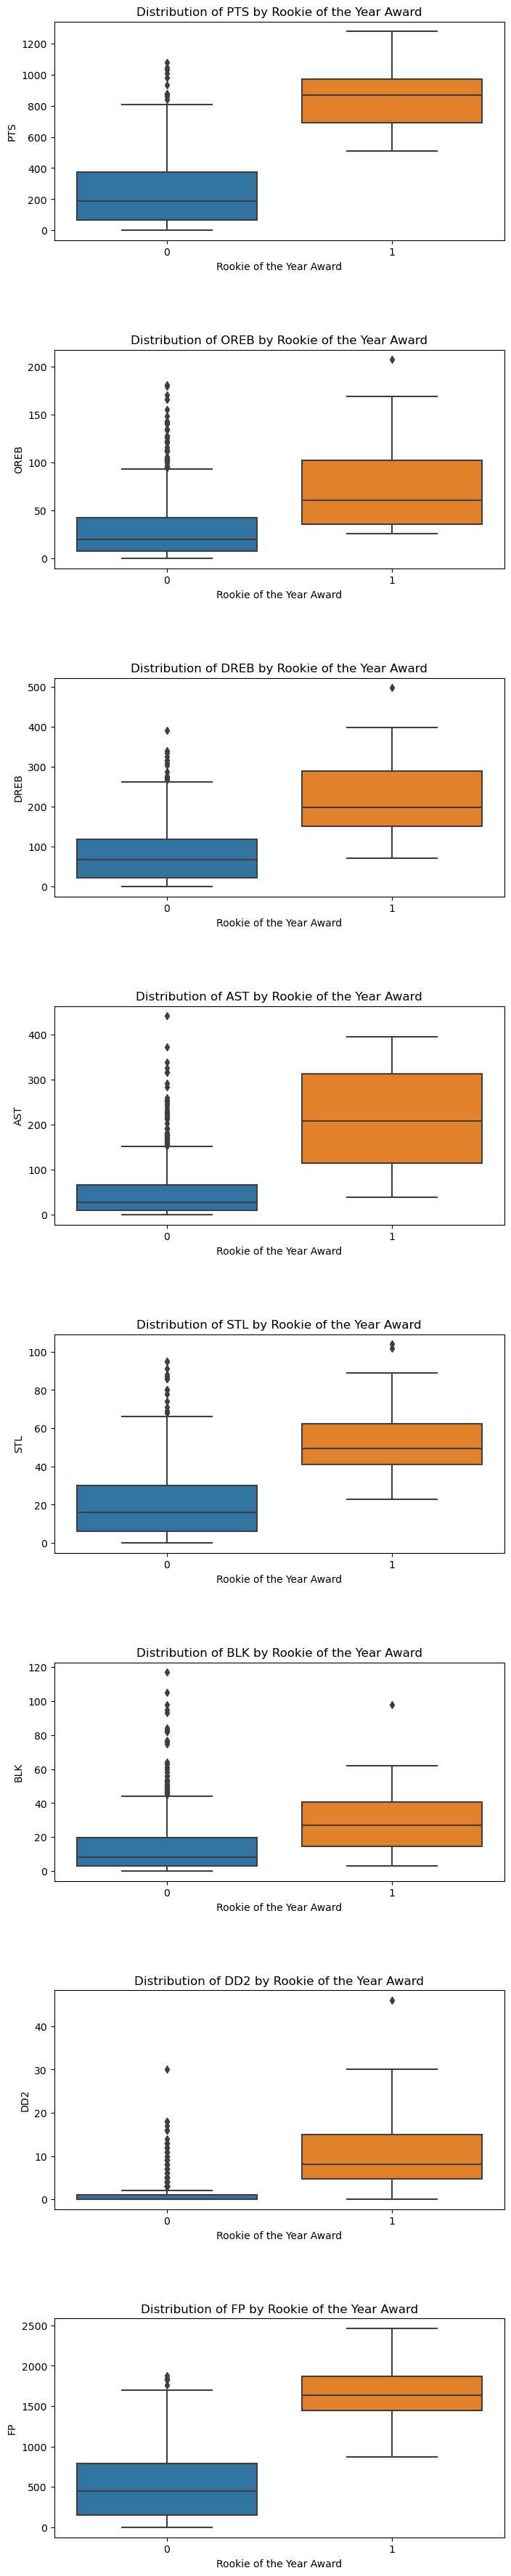

In [21]:
potential_features = ['PTS', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'DD2', 'FP']

# Create subplots for each statistic
fig, axes = plt.subplots(nrows=len(potential_features), ncols=1, figsize=(8, 45), gridspec_kw={'hspace': 0.50})

# Iterate through the statistics and create box plots
for i, feature in enumerate(potential_features):
    sns.boxplot(x = 'Rookie of the Year', y = feature, data = rookies_df, ax = axes[i])
    axes[i].set_title(f'Distribution of {feature} by Rookie of the Year Award')
    axes[i].set_xlabel('Rookie of the Year Award')
    axes[i].set_ylabel(feature)

# Show the plots
plt.show()


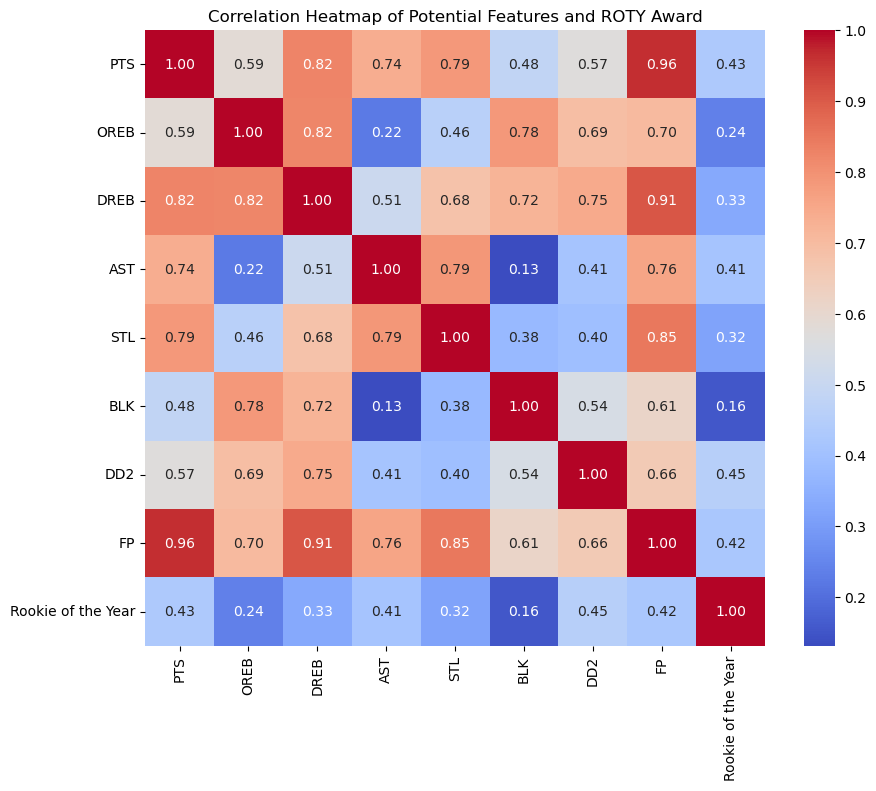

In [22]:
potential_features_and_target = ['PTS', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'DD2', 'FP', 'Rookie of the Year']

# Create a correlation matrix to visualize relationships between each feature
corr_matrix = rookies_df[potential_features_and_target].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap, show values on cells
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Heatmap of Potential Features and ROTY Award")

# Show the plot
plt.show()

Doubles-Doubles, points, assists, and fantasy points show the greatest linear correlation to Rookie of the Year Award whereas blocks show the least. This is likely due to the overlap between the distribution of blocks for winners and non-winners of the Rookie of the Year Award, in addition to the presence of many outliers in the non-winner distribution. It can hence be inferred that blocks will be a poor predictor of Rookie of the Year winners, so they will be excluded from the model.

### Features to Be Used to Train Model 1
- Points
- Offensive Rebounds
- Defensive Rebounds
- Assists 
- Steals
- Double-Doubles 

### Features to Be Used to Train Model 2
- Fantasy Points
- Double-Doubles

## Train Model 1

### Split the data intro training and testing sets

In [23]:
seasons = rookies_df['Rookie Season'].unique()

# Split the data at the 2018-19 season
split_season = seasons[-5]

# train_set consists of all seasons before 2018-19 season
train_set = rookies_df[rookies_df['Rookie Season'] < split_season]

# test_set consists of 2018-19 season to 2022-23 season
test_set = rookies_df[rookies_df['Rookie Season'] >= split_season]

In [24]:
train_set

,Player,Team,Age,GP,W,L,Min,PTS,FGM,FGA,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie Season,Rookie of the Year
0,Caron Butler,MIA,23,49,17,32,1804.5,681,241,608,...,107,86,17,140,1396,3,0,-128,2002-03,0
1,Amar'e Stoudemire,PHX,20,50,29,21,1562.1,640,220,489,...,110,38,45,166,1389,18,0,-27,2002-03,1
2,Yao Ming,HOU,22,48,26,22,1330.1,622,227,429,...,94,15,95,136,1439,16,0,18,2002-03,0
3,Drew Gooden,ORL,21,47,13,34,1258.6,586,244,547,...,100,37,21,114,1092,5,0,-153,2002-03,0
4,Dajuan Wagner,CLE,20,35,7,28,1081.1,507,182,489,...,63,34,5,83,777,1,0,-162,2002-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,D.J. Wilson,MIL,22,19,10,9,60.3,16,7,12,...,4,1,1,5,29,0,0,-41,2017-18,0
461,Ante Zizic,CLE,21,14,9,5,45.4,15,5,12,...,2,0,4,5,46,0,0,-25,2017-18,0
462,Furkan Korkmaz,PHI,20,6,3,3,32.0,9,3,12,...,1,1,0,4,21,0,0,-3,2017-18,0
463,Tony Bradley,UTA,20,8,5,3,27.7,8,3,11,...,0,0,0,1,23,0,0,1,2017-18,0


In [25]:
test_set

,Player,Team,Age,GP,W,L,Min,PTS,FGM,FGA,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Rookie Season,Rookie of the Year
465,Luka Doncic,DAL,20,55,25,30,1772.4,1140,377,877,...,178,57,15,102,2113,13,3,-17,2018-19,1
466,Trae Young,ATL,20,58,19,39,1742.8,980,337,831,...,229,51,13,97,1838,18,0,-344,2018-19,0
467,Deandre Ayton,PHX,20,53,11,42,1638.7,877,386,657,...,96,42,49,151,1877,30,0,-293,2018-19,0
468,Collin Sexton,CLE,20,58,12,46,1765.8,873,334,818,...,129,30,3,141,1308,1,0,-522,2018-19,0
469,Jaren Jackson Jr.,MEM,19,58,23,35,1514.7,798,298,589,...,98,52,82,220,1524,2,0,-103,2018-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Blake Wesley,SAS,20,15,2,13,195.9,63,25,66,...,20,5,1,28,115,0,0,-68,2022-23,0
610,Wendell Moore Jr.,MIN,21,24,13,11,139.3,36,15,37,...,8,6,5,13,104,0,0,-49,2022-23,0
611,Dalen Terry,CHI,20,23,11,12,114.6,35,15,37,...,6,4,4,9,94,0,0,-10,2022-23,0
612,Peyton Watson,DEN,20,12,8,4,37.9,19,9,17,...,2,0,1,2,31,0,0,-40,2022-23,0


### Extract Independent and Dependent Variables

In [26]:
# Training set
X_train1 = train_set[['PTS', 'OREB', 'DREB', 'AST', 'STL', 'DD2']].values
y_train = train_set['Rookie of the Year'].values 

# Testing set
X_test1 = test_set[['PTS', 'OREB', 'DREB', 'AST', 'STL', 'DD2']].values
y_test = test_set[['Rookie of the Year']].values 

### Standardize the Data

Standardizing the data to a common scale will help the optimization algorithm determine coefficients more quickly. It will also improve the readability of these coefficients.`

In [27]:
scaler = StandardScaler()
X_train1_standardized = scaler.fit_transform(X_train1)
X_test1_standardized = scaler.fit_transform(X_test1)

### Fit the Model

In [28]:
model1 = LogisticRegression(class_weight = 'balanced', random_state = 0, max_iter = 125)
model1.fit(X_train1_standardized, y_train)

LogisticRegression(class_weight='balanced', max_iter=125, random_state=0)

In [29]:
y_predicted1 = model1.predict(X_test1_standardized)

### Preliminary Model 1 Evaluation

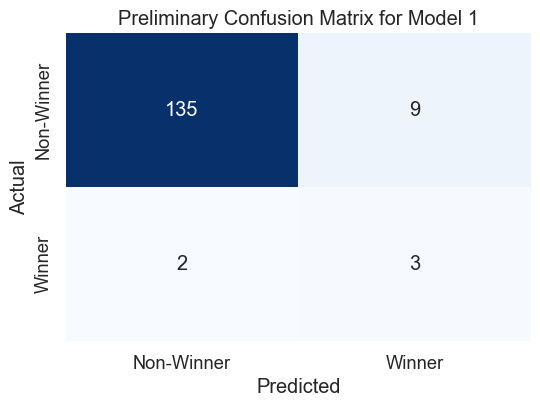

In [30]:
cm1 = confusion_matrix(y_test, y_predicted1)

# Define class labels 
class_names = ['Non-Winner', 'Winner']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2) 
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Preliminary Confusion Matrix for Model 1')
plt.show()

This preliminary evaluation is a bit misleading since it classifies players as winners or non-winners depending on whether their predicted probability of winning the award is greater than 0.5. This classification system does not make sense in the context of our problem since only one  player can win the NBA Rookie of the Year Award each season. A better system is to split the testing set up by seasons and calculate the probability that a player wins Rookie of the Year using our model for each player in the season. The player that has the highest probability of winning the award will be declared a predicted winner. We will then compare the predicted winners to the actual winners with a confusion matrix to assess the model's performance. Before that, however, we will tune the model by examining feature importance and adjusting hyperparameters.

### Evaluate Feature Importance

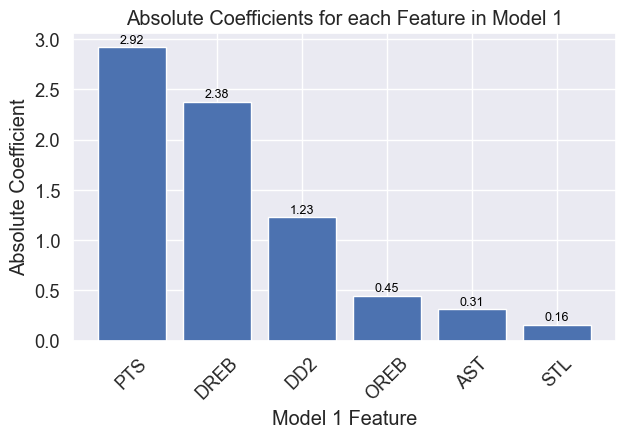

In [31]:
model1_features = train_set[['PTS', 'OREB', 'DREB', 'AST', 'STL', 'DD2']].columns

# Access the coefficients for winner class
coefficients_model1 = model1.coef_[0]

# Evaluate features based on the absolute value of their coefficients
model1_absolute_coeffs = [(feature, abs(coef)) for feature, coef in zip(model1_features, 
                                                                       coefficients_model1)]
model1_absolute_coeffs = sorted(model1_absolute_coeffs, key=lambda x: x[1], reverse=True)

# Visualize feature importance
features, importance = zip(*model1_absolute_coeffs)
plt.figure(figsize=(7, 4))
bars = plt.bar(features, importance)
plt.xticks(rotation=45)
plt.xlabel('Model 1 Feature')
plt.ylabel('Absolute Coefficient')
plt.title('Absolute Coefficients for each Feature in Model 1')

# Add labels to the bars
for bar, importance in zip(bars, importance):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, bar_height + 0.01, round(importance, 2), ha='center', 
             va='bottom', color='black', fontsize=9)
    
plt.show()

This graph suggests steals and assists are the least significant metrics for determining the likelihood a player wins the Rookie of the Year Award. This is somewhat surprising since these metrics had a relatively high winner average to non-winner average ratio. The Pearson correlation coefficients between these metrics and the Rookie of the Year Award, displayed on the heatmap, were also relatively high. I attribute the discrepancy to the presence of outliers in the distributions of both metrics in addition to the wide range of values in the winner distribution of assists. Regardless, none of the absolute coefficients approximate to 0, so I will retain all of these features for now. 

### Using Grid SearchCV to Tune Hyperparameters

In [32]:
# Define a distributution of possible hyperparameter values for penalty, regularization strength
# and class weights
parameter_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10], 
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}],  
}

# Use logistic regression as the base template
model1_template = LogisticRegression(max_iter = 125, solver = 'liblinear')

# Initialize the Grid Search with F1-score as the scoring metric
grid_search1 = GridSearchCV(model1_template, parameter_distributions, scoring = 'f1')

# Fit the Grid Search, continuing to use the standardized data for consistency
# and interpretability
grid_search1.fit(X_train1_standardized, y_train)

results1 = grid_search1.cv_results_

# Extract the hyperparameters and their corresponding F1-scores
params1 = results1['params']
f1_scores1 = results1['mean_test_score']

# Print the parameters and corresponding F1-scores
for param, f1_score in zip(params1, f1_scores1):
    print(f"Parameters: {param} - F1-Score: {f1_score}")

print(f"\nThe best set of parameters is: {grid_search1.best_params_}")
print(f"The corresponding f1-score is: {grid_search1.best_score_}")


Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'} - F1-Score: 0.3697513013302487
Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'} - F1-Score: 0.3313131313131313
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1'} - F1-Score: 0.5470129870129872
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2'} - F1-Score: 0.5361038961038962
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l1'} - F1-Score: 0.47417027417027413
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2'} - F1-Score: 0.4504761904761905
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 20}, 'penalty': 'l1'} - F1-Score: 0.4098245614035088
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 20}, 'penalty': 'l2'} - F1-Score: 0.42095238095238097
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'} - F1-Score: 0.4142657342657342
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'} - F1-Score: 0.4228571428571

Now that we have our optimal set of parameters, we'll use them to fit model 1. 

### Refitting Model 1

In [33]:
model1_refined = LogisticRegression(C = 1, class_weight = {0: 1, 1: 5}, max_iter = 125, penalty = 'l2',
                   solver = 'liblinear')
model1_refined.fit(X_train1_standardized, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 5}, max_iter=125,
                   solver='liblinear')

Now that the new model has been fit, we will calculate the players' probabilities of winning the award for each season, select the player with the highest probability as the predicted winner, and evaluate the model's performance by comparing the predicted winners to the actual winners. 

## Evaluating Refined Model 1

### Calculating Probabilities that Players Won the Rookie of the Year Award 

In [34]:
# Calculate probabilities that players in the test set won Rookie of the Year Award using the model
y_predicted_probabilities1 = model1_refined.predict_proba(X_test1_standardized)

# Get unique seasons and players  from test set 
seasons = test_set['Rookie Season'].unique()
players = test_set['Player'].unique()

# Create empty list to store calculated probabilities
player_probabilities1 = []

columns = ['Season', 'Player', 'Probability of Winning Rookie of the Year']

# Create dataframe containing rookie season, player name, and probability of winning rookie of the year award 
for season in seasons:
    # Access the probability that the player won the Rookie of the Year Award 
    # (second columum of y_predicted_probabilities2)
    # Ensure we are extracting a single probability value by accessing the first array element
    players_in_season = test_set[test_set['Rookie Season'] == season]['Player'].unique()
    for player_name in players_in_season:
        probability = y_predicted_probabilities1[(players == player_name), 1][0]
        player_probabilities1.append([season, player_name, probability])

player_probs_df1 = pd.DataFrame(player_probabilities1, columns = columns)

# Create a list to store all Rookie of the Year predictions (1 if they 
# have the highest probability of winning the award, 0 otherwise)
y_predicted1_refined = []

# Sort the dataframe of probabilities from highest to lowest and
# display probability tables for each season 
player_probs_df1_sorted = player_probs_df1.sort_values(by = 'Probability of Winning Rookie of the Year', ascending=False)
for season in seasons:
    display(player_probs_df1_sorted[player_probs_df1_sorted['Season'] == season])
    
# Initialize an empty list to store predicted winners
predicted_winners1 = []

# Season data consists of all player's in the season and their probabilities of winning the award
for season in seasons:
    season_data = player_probs_df1[player_probs_df1['Season'] == season]
    
    # Find max probability of winning Rookie of the Year Award for the season
    max_prob = max(season_data['Probability of Winning Rookie of the Year'])
    
    # The player is the predicted winner for that season if their probability of winning is the maximum
    # probability of winning for that season. So, add them to the list of predicted winners.
    predicted_season_winner1 = season_data[season_data['Probability of Winning Rookie of the Year'] == max_prob]['Player'].tolist()
    predicted_winners1.extend(predicted_season_winner1)


# Created the predicted list of winners and non-winners for the confusion matrix            
y_predicted1_refined = [1 if player in predicted_winners1 else 0 for player in players]
    

,Season,Player,Probability of Winning Rookie of the Year
1,2018-19,Trae Young,0.993168
2,2018-19,Deandre Ayton,0.945787
0,2018-19,Luka Doncic,0.807901
3,2018-19,Collin Sexton,0.458789
7,2018-19,Marvin Bagley III,0.215227
4,2018-19,Jaren Jackson Jr.,0.168197
6,2018-19,Shai Gilgeous-Alexander,0.112823
9,2018-19,Landry Shamet,0.080543
8,2018-19,Kevin Huerter,0.048721
5,2018-19,Kevin Knox II,0.046751


,Season,Player,Probability of Winning Rookie of the Year
29,2019-20,Ja Morant,0.860513
30,2019-20,Darius Garland,0.306769
32,2019-20,RJ Barrett,0.052897
31,2019-20,De'Andre Hunter,0.048596
37,2019-20,Jarrett Culver,0.045371
33,2019-20,Coby White,0.039815
40,2019-20,Jaxson Hayes,0.037012
39,2019-20,Rui Hachimura,0.033334
47,2019-20,Zion Williamson,0.029646
35,2019-20,Brandon Clarke,0.028219


,Season,Player,Probability of Winning Rookie of the Year
58,2020-21,LaMelo Ball,0.203719
61,2020-21,Tyrese Haliburton,0.059092
59,2020-21,Anthony Edwards,0.051066
60,2020-21,Immanuel Quickley,0.046250
68,2020-21,Isaac Okoro,0.020856
67,2020-21,Tyrese Maxey,0.017064
63,2020-21,Saddiq Bey,0.016302
69,2020-21,Payton Pritchard,0.014899
66,2020-21,Desmond Bane,0.014111
62,2020-21,Patrick Williams,0.013801


,Season,Player,Probability of Winning Rookie of the Year
89,2021-22,Franz Wagner,0.343055
94,2021-22,Josh Giddey,0.286685
90,2021-22,Evan Mobley,0.227622
92,2021-22,Cade Cunningham,0.199970
91,2021-22,Scottie Barnes,0.121467
96,2021-22,Davion Mitchell,0.105509
95,2021-22,Jalen Green,0.090630
93,2021-22,Chris Duarte,0.064521
97,2021-22,Jalen Suggs,0.054217
103,2021-22,Josh Christopher,0.041854


,Season,Player,Probability of Winning Rookie of the Year
121,2022-23,Paolo Banchero,0.648560
122,2022-23,Jaden Ivey,0.525765
120,2022-23,Bennedict Mathurin,0.497742
125,2022-23,Jalen Williams,0.080841
124,2022-23,Keegan Murray,0.077110
129,2022-23,Walker Kessler,0.071916
126,2022-23,AJ Griffin,0.071706
131,2022-23,Jalen Duren,0.058746
127,2022-23,Tari Eason,0.057165
130,2022-23,Shaedon Sharpe,0.037484


### Generate and Display the Confusion Matrix

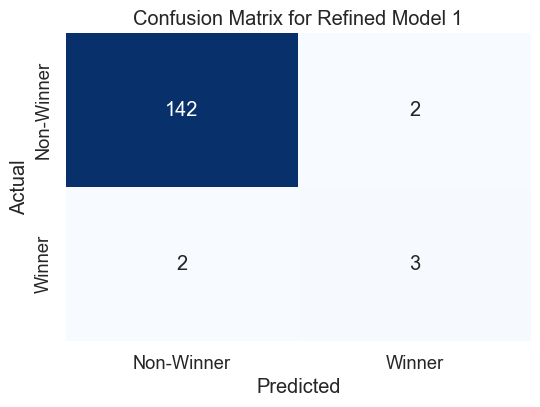

In [35]:
cm1_refined = confusion_matrix(y_test, y_predicted1_refined)

class_names = ['Non-Winner', 'Winner']

plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2) 
sns.heatmap(cm1_refined, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Refined Model 1')
plt.show()

The model has correctly 3 of the 5 Rookie of the Year Award winners from the last 5 NBA seasons. Note that the false positives and false negatives is the same because we only used the model to predict 5 instances of the positive class. Thus, the precision  and recall are the same: 0.6.

### Model 1 Refined Absolute Coefficients

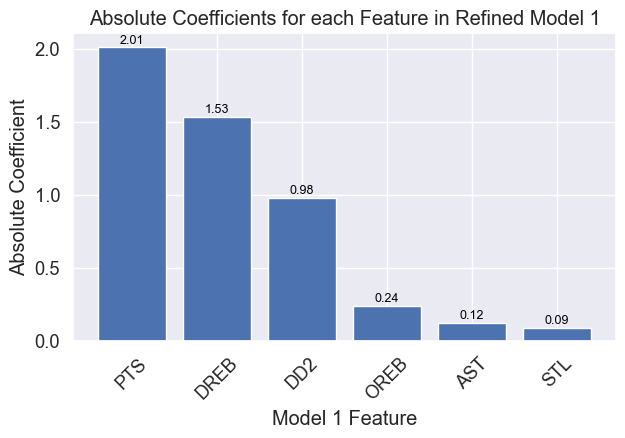

In [36]:
model1_features = train_set[['PTS', 'OREB', 'DREB', 'AST', 'STL', 'DD2']].columns

# Access the coefficients for winner class
coefficients_model1 = model1_refined.coef_[0]

# Evaluate features based on the absolute value of their coefficients
model1_absolute_coeffs = [(feature, abs(coef)) for feature, coef in zip(model1_features, 
                                                                       coefficients_model1)]
model1_absolute_coeffs = sorted(model1_absolute_coeffs, key=lambda x: x[1], reverse=True)

# Visualize feature importance
features, importance = zip(*model1_absolute_coeffs)
plt.figure(figsize=(7, 4))
bars = plt.bar(features, importance)
plt.xticks(rotation=45)
plt.xlabel('Model 1 Feature')
plt.ylabel('Absolute Coefficient')
plt.title('Absolute Coefficients for each Feature in Refined Model 1')

# Add labels to the bars
for bar, importance in zip(bars, importance):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, bar_height + 0.01, round(importance, 2), ha='center', 
             va='bottom', color='black', fontsize=9)
    
plt.show()

These results are in line with the absolute coefficients calculated for the preliminary model; points, rebounds, and double-doubles seem to have the biggest influence on Rookie of the Year selection whereas assists and steals are relatively insignificant. Since the latter two are closer to 0 relative to the preliminary model, it may be worth retraining the model without these features in a future project. 

## Train Model 2

In [37]:
# Training set
X_train2 = train_set[['FP', 'DD2']].values

# Testing set
X_test2 = test_set[['FP', 'DD2']].values

# Note that y_train and y_test remain the same across Model 1 and Model 2

### Standardize the Data

In [38]:
X_train2_standardized = scaler.fit_transform(X_train2)
X_test2_standardized = scaler.fit_transform(X_test2)

### Fit the Model

In [39]:
model2 = LogisticRegression(class_weight = 'balanced', random_state = 0, max_iter = 125)
model2.fit(X_train2_standardized, y_train)

LogisticRegression(class_weight='balanced', max_iter=125, random_state=0)

In [40]:
y_predicted2 = model2.predict(X_test2_standardized)

### Preliminary Model 2 Evaluation

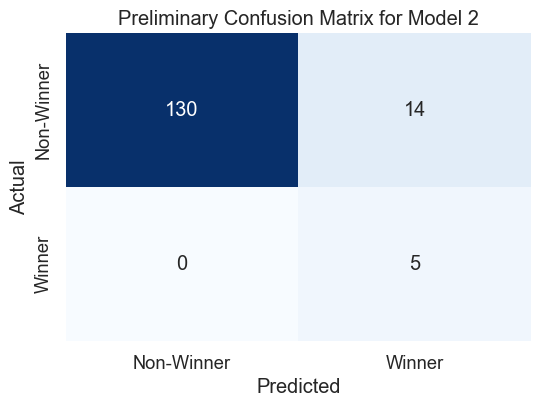

In [41]:
cm2 = confusion_matrix(y_test, y_predicted2)

# Define class labels 
class_names = ['Non-Winner', 'Winner']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2) 
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Preliminary Confusion Matrix for Model 2')
plt.show()

All predicted winners were actual Rookie of the Year winners. However, 14 predicted winners were non-winners. The precision is about 0.26 and the recall is 1. Let's tune the model to find a better balance between these metrics. Since only two features are being used to train this model, there is no need to analyze the regression coefficients; we can infer both fantasy points and double-doubles are important from our past data analysis. To tune the hyperparameters, we can use the same parameter distributions used to tune model 1 since they originate from the same data source.

### Using Grid SearchCV to Tune Hyperparameters

In [42]:
# Use logistic regression as the base template
model2_template = LogisticRegression(max_iter = 125, solver = 'liblinear')

# Initialize the Grid Search with F1-score as the scoring metric
grid_search2 = GridSearchCV(model2_template, parameter_distributions, scoring = 'f1')

# Fit the Grid Search
grid_search2.fit(X_train2_standardized, y_train)

results2 = grid_search2.cv_results_

# Extract the hyperparameters and their corresponding F1-scores
params2 = results2['params']
f1_scores2 = results2['mean_test_score']

# Print the parameters and corresponding F1-scores
for param, f1_score in zip(params2, f1_scores2):
    print(f"Parameters: {param} - F1-Score: {f1_score}")

print(f"\nThe best set of parameters is: {grid_search2.best_params_}")
print(f"The corresponding f1-score is: {grid_search2.best_score_}")

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'} - F1-Score: 0.32623376623376626
Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'} - F1-Score: 0.31204404291360816
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1'} - F1-Score: 0.4993939393939394
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2'} - F1-Score: 0.6033333333333333
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l1'} - F1-Score: 0.5031746031746032
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2'} - F1-Score: 0.47110389610389614
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 20}, 'penalty': 'l1'} - F1-Score: 0.36982456140350883
Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 20}, 'penalty': 'l2'} - F1-Score: 0.34399600399600405
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'} - F1-Score: 0.33894105894105897
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'} - F1-Score: 0.333226773

### Refitting Model 2

In [43]:
model2_refined = LogisticRegression(C = 0.1, class_weight = {0: 1, 1: 5}, max_iter = 125, penalty = 'l2',
                   solver = 'liblinear')
model2_refined.fit(X_train2_standardized, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 5}, max_iter=125,
                   solver='liblinear')

Now, let's use the refined Model 2 to predict players' probabilities of winning the award for each season, just as we did for Model 1.

## Evaluating Refined Model 2

### Predict the Probabilities of Players in the Test-Set being a Rookie of the Year Award Winner

In [44]:
# Calculate probabilities that players in the test set won Rookie of the Year Award using the model
y_predicted_probabilities2 = model2_refined.predict_proba(X_test2_standardized)

# Create empty list to store calculated probabilities
player_probabilities2 = []

# Create dataframe containing rookie season, player name, and probability of winning rookie of the year award 
for season in seasons:
    players_in_season = test_set[test_set['Rookie Season'] == season]['Player'].unique()
    for player_name in players_in_season:
        # Access the probability that the player won the Rookie of the Year Award 
        # (second columum of y_predicted_probabilities2)
        # Ensure we are extracting a single probability value by accessing the first array element
        probability = y_predicted_probabilities2[(players == player_name), 1][0]
        # Add season, player's name, and corresponding probability of winning the award to a list
        player_probabilities2.append([season, player_name, probability])

# Create a Pandas dataframe with the calculated probabilities, players' names, and rookie seasons
player_probs_df2 = pd.DataFrame(player_probabilities2, columns = columns)

# Create a list for storing predicted Rookie of the Year Award winner status
y_predicted2_refined = []

# Sort the dataframe of probabilities from highest to lowest and
# display probability tables for each season 
player_probs_df2_sorted = player_probs_df2.sort_values(by = 'Probability of Winning Rookie of the Year', ascending=False)
for season in seasons:
    display(player_probs_df2_sorted[player_probs_df2_sorted['Season'] == season])
    
# Initialize an empty list to store predicted winners
predicted_winners2 = []

# Season data consists of all player's in the season and their probabilities of winning the award
for season in seasons:
    season_data = player_probs_df2[player_probs_df2['Season'] == season]
    
    # Find max probability of winning Rookie of the Year Award for the season
    max_prob = max(season_data['Probability of Winning Rookie of the Year'])
    
    # The player is the predicted winner for that season if their probability of winning is the maximum
    # probability of winning for that season. So, add them to the list of predicted winners.
    predicted_season_winner2 = season_data[season_data['Probability of Winning Rookie of the Year'] == max_prob]['Player'].tolist()
    predicted_winners2.extend(predicted_season_winner2)

# Created the predicted list of winners and non-winners for the confusion matrix            
y_predicted2_refined = [1 if player in predicted_winners2 else 0 for player in players]

,Season,Player,Probability of Winning Rookie of the Year
2,2018-19,Deandre Ayton,0.878643
0,2018-19,Luka Doncic,0.797594
1,2018-19,Trae Young,0.756111
4,2018-19,Jaren Jackson Jr.,0.369798
7,2018-19,Marvin Bagley III,0.297804
11,2018-19,Wendell Carter Jr.,0.264747
3,2018-19,Collin Sexton,0.261706
6,2018-19,Shai Gilgeous-Alexander,0.224136
10,2018-19,Mikal Bridges,0.202611
8,2018-19,Kevin Huerter,0.173268


,Season,Player,Probability of Winning Rookie of the Year
29,2019-20,Ja Morant,0.511932
36,2019-20,P.J. Washington,0.246026
35,2019-20,Brandon Clarke,0.216059
32,2019-20,RJ Barrett,0.210929
31,2019-20,De'Andre Hunter,0.196575
33,2019-20,Coby White,0.177257
30,2019-20,Darius Garland,0.174438
40,2019-20,Jaxson Hayes,0.157775
37,2019-20,Jarrett Culver,0.153930
34,2019-20,Tyler Herro,0.150513


,Season,Player,Probability of Winning Rookie of the Year
58,2020-21,LaMelo Ball,0.315845
61,2020-21,Tyrese Haliburton,0.133988
59,2020-21,Anthony Edwards,0.130148
62,2020-21,Patrick Williams,0.095684
71,2020-21,Isaiah Stewart,0.084108
63,2020-21,Saddiq Bey,0.081562
60,2020-21,Immanuel Quickley,0.080365
64,2020-21,James Wiseman,0.080350
65,2020-21,Cole Anthony,0.070438
68,2020-21,Isaac Okoro,0.065911


,Season,Player,Probability of Winning Rookie of the Year
94,2021-22,Josh Giddey,0.674000
90,2021-22,Evan Mobley,0.626170
89,2021-22,Franz Wagner,0.445369
91,2021-22,Scottie Barnes,0.437008
92,2021-22,Cade Cunningham,0.382126
93,2021-22,Chris Duarte,0.205589
99,2021-22,Alperen Sengun,0.199454
96,2021-22,Davion Mitchell,0.171973
97,2021-22,Jalen Suggs,0.158888
95,2021-22,Jalen Green,0.136742


,Season,Player,Probability of Winning Rookie of the Year
121,2022-23,Paolo Banchero,0.636434
129,2022-23,Walker Kessler,0.479533
122,2022-23,Jaden Ivey,0.395241
123,2022-23,Jabari Smith Jr.,0.393198
131,2022-23,Jalen Duren,0.379100
120,2022-23,Bennedict Mathurin,0.317101
125,2022-23,Jalen Williams,0.274494
127,2022-23,Tari Eason,0.252121
124,2022-23,Keegan Murray,0.245478
128,2022-23,Jeremy Sochan,0.160130


### Generate the Confusion Matrix for Refined Model 2

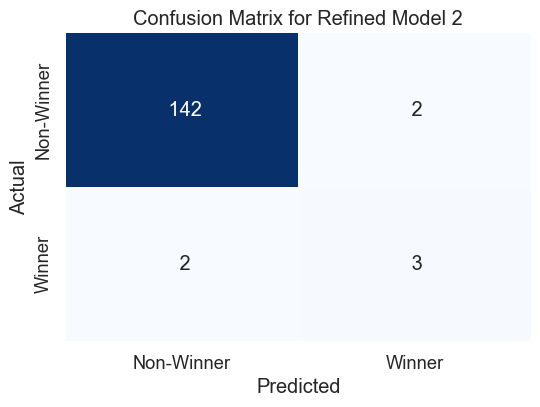

In [45]:
cm2_refined = confusion_matrix(y_test, y_predicted2_refined)

# Define class labels 
class_names = ['Non-Winner', 'Winner']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2) 
sns.heatmap(cm2_refined, annot = True, fmt =' d', cmap = 'Blues', cbar = False,
            xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Refined Model 2')
plt.show()

Model 2 has correctly predicted 3 of the 5 Rookie of the Year Award winners of the last 5 NBA seasons, yielding a precision and recall of 0.6. 

### Model 2 Refined Absolute Coefficients

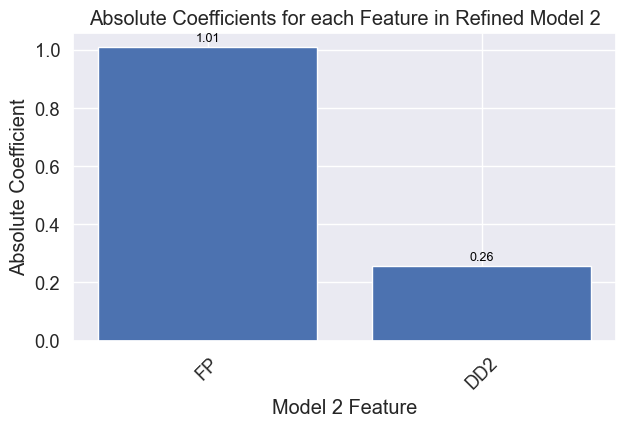

In [46]:
model2_features = train_set[['FP', 'DD2']].columns

# Access the coefficients for winner class
coefficients_model2 = model2_refined.coef_[0]

# Evaluate features based on the absolute value of their coefficients
model2_absolute_coeffs = [(feature, abs(coef)) for feature, coef in zip(model2_features, 
                                                                       coefficients_model2)]
model2_absolute_coeffs = sorted(model2_absolute_coeffs, key=lambda x: x[1], reverse=True)

# Visualize feature importance
features, importance = zip(*model2_absolute_coeffs)
plt.figure(figsize=(7, 4))
bars = plt.bar(features, importance)
plt.xticks(rotation=45)
plt.xlabel('Model 2 Feature')
plt.ylabel('Absolute Coefficient')
plt.title('Absolute Coefficients for each Feature in Refined Model 2')

# Add labels to the bars
for bar, importance in zip(bars, importance):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, bar_height + 0.01, round(importance, 2), ha='center', 
             va='bottom', color='black', fontsize=9)
    
plt.show()

Fantasy points appears to have more influence in predicting Rookie of the Year winners than double-doubles in Model 2. This was expected because fantasy points is more encompassing of overall player performance; it combines multiple performance metrics. 

## Conclusion


In this notebook, I implemented two Logistic Regression models to predict NBA Rookie of the Year Award winners. I accomplished this by scraping rookie year statistics from nba.com, separating the dataset into players who won the award and those who did not, analyzing their summary statistics independently, and then comparing them to select the most relevant features for training the models. Collected statistics were limited to the pre-All-Star break performance of first-round draft picks to maximize the models' predictive capabilities. I chose to train two models to counteract the effects of multicollinearity between similar features. Model 1 was trained using players' total points, defensive rebounds, offensive rebounds, assists, steals, and double-doubles from the 2002-03 to 2017-18 season. Model 2 was trained using total fantasy points and doubles-doubles over the same seasons. To evaluate the performance of the models, players from the 2018-19 season to 2022-23 seasons were divided up by season. Then, the models were used to calculate players' probabilities of winning the award. Players with the highest probability in each season were declared predicted winners of the award. 

Both Models 1 and 2 met my goal of correctly predicting at least 3 of the last 5 NBA Rookie of the Year Award winners. However, given the small size of both the training and testing sets, more data is needed to assess the generalized performance of these models. A possible improvement to this project using a resampling technique to better handle the class imbalance between winners and non-winners, such as the Synthetic Minority Over-Sampling Technique (Brownlee, 2020). It may also be helpful to collect data related to players' general popularity during their rookie season, as this could influence voters' decision-making. For example, one might consider adding hours of media coverage and social media followers to the dataset. A combination of these approaches may result in more correct predictions.

Working on this project has been invaluable to the development of my analytical and machine-learning skills. I look forward to expanding my knowledge and skillset throughout the rest of PSU's Data Science program.

## References

### Dataset and Software

The dataset used for this project was created by web scraping various *NBA Advanced Stats* webpages using the *Selenium* Python library. <br>
Data analysis and model development were implemented through these Python libraries: 
- Pandas 
- NumPy
- Seaborn 
- Matplotlib
- SciPy
- Scikit Learn

### Text Sources

- Barutha, A. (2023, August 17). *Advice for NBA Fans New to Fantasy Basketball*. NBA Fantasy. https://www.nba.com/news/advice-for-nba-fans-new-to-fantasy-basketball 
 - Brownlee, J. (2020, August 15). *8 Tactics to Combat Imbalanced Classes in your Machine Learning Dataset*. Machine Learning Mastery. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/  
- Sportskeeda. (2023). *List of NBA Rookie of the Year Award Winners*. Sportskeeda. https://www.sportskeeda.com/basketball/list-of-nba-rookie-of-the-year-award-winners 